In [73]:
import numpy as np
import GPy
import deepgp
import scipy
import sklearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [92]:
def plot_model(m):
    x = m.X
    y = m.Y
    N = len(x)
    X = (np.arange(2*N)/N -0.5).reshape(-1,1)
    plt.figure(figsize=(10,3.2))
    plt.xlim(-0.5,1.5)
    plt.plot(X, m.predict(X)[0], c='k', label='predicted mean');
    up = (m.predict(X)[0]+2*np.sqrt(m.predict(X)[1])).reshape(-1)
    low = (m.predict(X)[0]-2*np.sqrt(m.predict(X)[1])).reshape(-1)
    plt.fill_between(X.reshape(-1), up, low, where=up>low, facecolor=[0.7, 0.7, 0.7, 0.2], label='mean +/- 2 stddev')
    plt.scatter(x, y, c=[cm.coolwarm(0.9)], s=20, label='data');
    inducing = m.layers[-1].inducing_inputs.values if isinstance(m, deepgp.DeepGP) else m.inducing_inputs
    plt.scatter(inducing, np.ones(len(inducing))*np.min(low), color=cm.coolwarm(0.05), s=8, label='top layer inducing inputs');
    plt.xlabel('x'), plt.ylabel('y')
    plt.xticks([0,1]), plt.yticks([-1,0,1])
    plt.scatter([0],[0], s=0, label='log marginal likelihood: %.2f' % (m.log_likelihood()))
    plt.legend(loc='upper left')
    plt.tight_layout()



# Generate step data

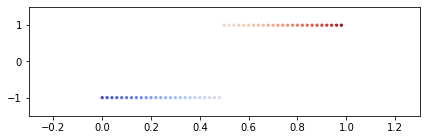

In [13]:
N = 50
np.random.seed(1)
X = np.arange(0,N).reshape(-1,1) / N
y = np.ones(N)
y[0:N//2] = -1
y = y.reshape(-1,1)

plt.rcParams['image.cmap'] = 'coolwarm'
c1 = X.copy().reshape(-1,1)
plt.figure(figsize=(7,2))
plt.scatter(X, y, c=c1, s=5); plt.xlim(-0.3,1.3); plt.ylim(-1.5,1.5);

# Baseline with classic GP

['Maximum number of f evaluations reached', 'Converged']


sparse_gp.,value,constraints,priors
inducing inputs,"(20, 1)",,
sum.rbf.variance,0.6782149176896799,+ve,
sum.rbf.lengthscale,0.07777444361630909,+ve,
sum.bias.variance,1.3350465066406147e-08,+ve,
Gaussian_noise.variance,0.037436110050390235,+ve,


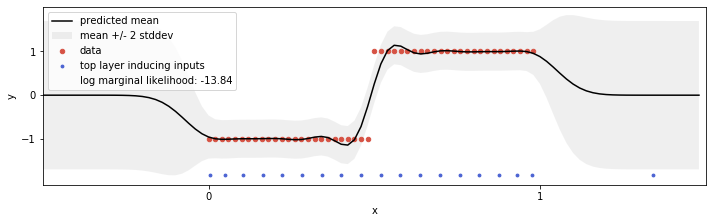

In [93]:
num_inducing = 20
m_GP = GPy.models.SparseGPRegression(X=X, Y=y, kernel=GPy.kern.RBF(X.shape[1])+GPy.kern.Bias(X.shape[1]), num_inducing=num_inducing)
m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.01
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=100)
m_GP.Gaussian_noise.variance.unfix()
m_GP.optimize(max_iters=400)
print([run.status for run in m_GP.optimization_runs])
plot_model(m_GP)
m_GP

# Fit 2 layer stacked GP

In [94]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 1

# Define what kernels to use per layer
kern1 = GPy.kern.RBF(1)
kern2 = GPy.kern.RBF(1)

# Number of inducing points to use
num_inducing = 20

m = deepgp.DeepGP([y.shape[1],Q,X.shape[1]],
                  y, X, kernels=[kern1, kern2], 
                  num_inducing=num_inducing, back_constraint=False)
m

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(20, 1)",,
obslayer.rbf.variance,1.0,+ve,
obslayer.rbf.lengthscale,1.0,+ve,
obslayer.Gaussian_noise.variance,1.0,+ve,
obslayer.Kuu_var,"(20,)",+ve,
obslayer.latent space.mean,"(50, 1)",,
obslayer.latent space.variance,"(50, 1)",+ve,
layer_1.inducing inputs,"(20, 1)",,
layer_1.rbf.variance,1.0,+ve,
layer_1.rbf.lengthscale,1.0,+ve,


['Maximum number of f evaluations reached']


deepgp.,value,constraints,priors
obslayer.inducing inputs,"(20, 1)",,
obslayer.rbf.variance,0.6253272543516353,+ve,
obslayer.rbf.lengthscale,0.2599128348659716,+ve,
obslayer.Gaussian_noise.variance,0.01,+ve fixed,
obslayer.Kuu_var,"(20,)",+ve,
obslayer.latent space.mean,"(50, 1)",,
obslayer.latent space.variance,"(50, 1)",+ve,
layer_1.inducing inputs,"(20, 1)",,
layer_1.rbf.variance,0.14884523549757048,+ve,
layer_1.rbf.lengthscale,0.1593510933376445,+ve,


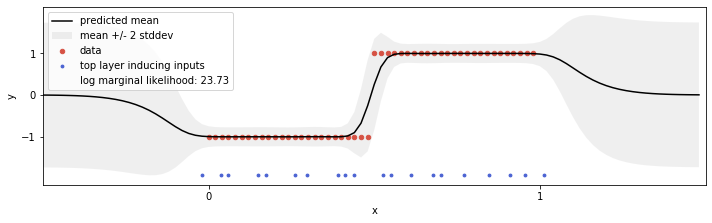

In [95]:
for layer in m.layers:
    layer.Gaussian_noise.variance = m.obslayer.Y.var()*0.01
    layer.Gaussian_noise.variance.fix()
m.optimize(max_iters=100)
print([run.status for run in m.optimization_runs])
plot_model(m)
m

['Maximum number of f evaluations reached', 'Maximum number of f evaluations reached']


deepgp.,value,constraints,priors
obslayer.inducing inputs,"(20, 1)",,
obslayer.rbf.variance,0.4910915496401747,+ve,
obslayer.rbf.lengthscale,1.3132420273689616,+ve,
obslayer.Gaussian_noise.variance,8.790194045368759e-23,+ve,
obslayer.Kuu_var,"(20,)",+ve,
obslayer.latent space.mean,"(50, 1)",,
obslayer.latent space.variance,"(50, 1)",+ve,
layer_1.inducing inputs,"(20, 1)",,
layer_1.rbf.variance,5.582272115858611,+ve,
layer_1.rbf.lengthscale,0.09515079007423015,+ve,


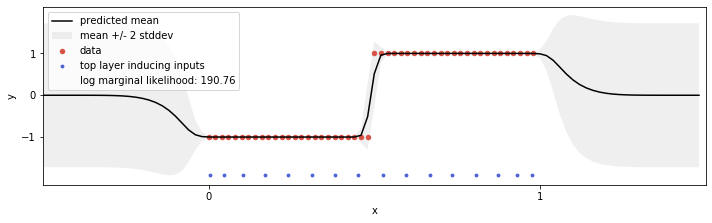

In [96]:
for layer in m.layers:
    layer.Gaussian_noise.variance.unfix()
m.optimize(max_iters=200)
print([run.status for run in m.optimization_runs])
plot_model(m)
m

# Fit 3 layer stacked GP

In [97]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 1

# Define what kernels to use per layer
kern1 = GPy.kern.RBF(1)
kern2 = GPy.kern.RBF(1)
kern3 = GPy.kern.RBF(1)

# Number of inducing points to use
num_inducing = 20

m = deepgp.DeepGP([y.shape[1],Q,Q,X.shape[1]],
                  y, X, kernels=[kern1, kern2, kern3], 
                  num_inducing=num_inducing, back_constraint=False)
m

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(20, 1)",,
obslayer.rbf.variance,1.0,+ve,
obslayer.rbf.lengthscale,1.0,+ve,
obslayer.Gaussian_noise.variance,1.0,+ve,
obslayer.Kuu_var,"(20,)",+ve,
obslayer.latent space.mean,"(50, 1)",,
obslayer.latent space.variance,"(50, 1)",+ve,
layer_1.inducing inputs,"(20, 1)",,
layer_1.rbf.variance,1.0,+ve,
layer_1.rbf.lengthscale,1.0,+ve,


['Maximum number of f evaluations reached']


deepgp.,value,constraints,priors
obslayer.inducing inputs,"(20, 1)",,
obslayer.rbf.variance,0.6696190781523333,+ve,
obslayer.rbf.lengthscale,0.33354973193635806,+ve,
obslayer.Gaussian_noise.variance,0.01,+ve fixed,
obslayer.Kuu_var,"(20,)",+ve,
obslayer.latent space.mean,"(50, 1)",,
obslayer.latent space.variance,"(50, 1)",+ve,
layer_1.inducing inputs,"(20, 1)",,
layer_1.rbf.variance,0.15815172099724914,+ve,
layer_1.rbf.lengthscale,0.3403609682259849,+ve,


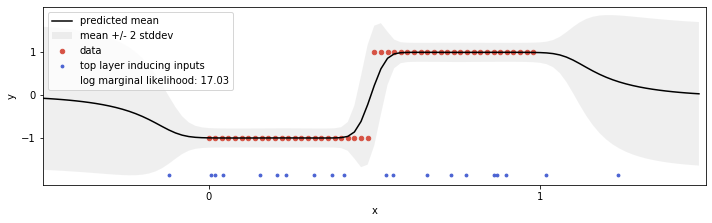

In [98]:
for layer in m.layers:
    layer.Gaussian_noise.variance = m.obslayer.Y.var()*0.01
    layer.Gaussian_noise.variance.fix()
m.optimize(max_iters=200)
print([run.status for run in m.optimization_runs])
plot_model(m)
m

['Maximum number of f evaluations reached', 'Maximum number of f evaluations reached']


deepgp.,value,constraints,priors
obslayer.inducing inputs,"(20, 1)",,
obslayer.rbf.variance,0.5503824469529944,+ve,
obslayer.rbf.lengthscale,2.577350388703883,+ve,
obslayer.Gaussian_noise.variance,1.77984744991727e-12,+ve,
obslayer.Kuu_var,"(20,)",+ve,
obslayer.latent space.mean,"(50, 1)",,
obslayer.latent space.variance,"(50, 1)",+ve,
layer_1.inducing inputs,"(20, 1)",,
layer_1.rbf.variance,12.016429995805298,+ve,
layer_1.rbf.lengthscale,0.41567944125984924,+ve,


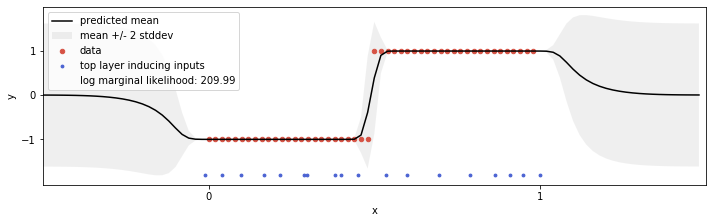

In [99]:
for layer in m.layers:
    layer.Gaussian_noise.variance.unfix()
m.optimize(max_iters=300)
print([run.status for run in m.optimization_runs])
plot_model(m)
m

# Conclusion

Stacked layer is able to fit data way better (in terms of marignal likelihood) than the classical GP. 3 layers seem to be justified over 2 according to marginal likelihood - Even if end-result does not show big differences.

One interpretaion might be, that according to occams razor two more constrained hidden layers are still more likeli than only one very flexibel one. This is also reflected in the lengthscales above. 2-layer have an order of magnitude shorter lengthsscales than the ones of the 3 layer